In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
from PIL import Image
import tensorflow.contrib.layers as layers

202599


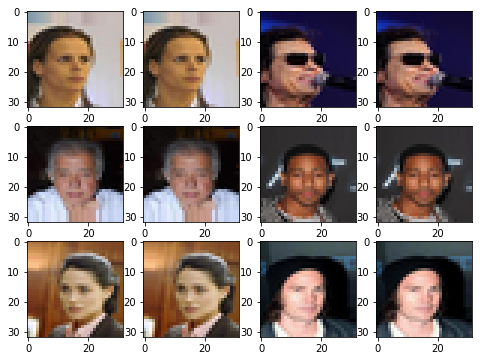

In [2]:
from os import listdir
from os.path import isfile, join
filepath = '../data/faces/img_align_celeba'
onlyfiles = [f for f in listdir(filepath) if isfile(join(filepath, f))]
print(len(onlyfiles))

def read_random_data_batch(filepath, batch_size, img_resize_shape):
    global onlyfiles
    TOTAL_NUMBER_OF_IMAGES = len(onlyfiles)
    images = []
    idxs = np.random.choice(TOTAL_NUMBER_OF_IMAGES, batch_size)
    for idx in idxs:
        img = Image.open(filepath+'/'+str(onlyfiles[idx]))
        img = img.resize((img_resize_shape[0],img_resize_shape[1]), Image.ANTIALIAS)
        img = np.array(img)/255.0
        images.append(img)
    return np.array(images), np.zeros(batch_size)

def display_images(images):
    images = images.reshape(images.shape[0], images.shape[1], images.shape[2], images.shape[3])
    random_indices = np.random.choice(images.shape[0], 8)
    idx = 0
    plt.figure(figsize=(8, 6))
    for i in range(2):
        for j in range(4):
            plt.subplot(2, 4, 4*i+j+1)
            plt.imshow(images[random_indices[idx]])
            idx += 1
    plt.show()

def display_pair(original, generated):
    original = original.reshape(original.shape[0], original.shape[1], original.shape[2], original.shape[3])
    generated = generated.reshape(generated.shape[0], generated.shape[1], generated.shape[2], generated.shape[3])
    random_indices = np.random.choice(images.shape[0], 6)
    idx = 0
    plt.figure(figsize=(8, 6))
    for i in range(3):
        for j in range(2):
            plt.subplot(3, 4, 4*i+2*j+1)
            plt.imshow(original[random_indices[idx]])
            plt.subplot(3, 4, 4*i+2*j+2)
            plt.imshow(generated[random_indices[idx]])
            idx += 1
    plt.show()

images, labels = read_random_data_batch(filepath, 64, [32, 32])
display_pair(images, images)

In [3]:
def encoder(input_tensor, output_size):
    '''Create encoder network.
    Args:
        input_tensor: a batch of images [batch_size, 32, 32, 3]
    Returns:
        A tensor that expresses the encoder network
    '''
    net = tf.layers.conv2d(input_tensor, 32, 3, strides=1, activation=tf.nn.elu)
    print("E1 - ", net.get_shape())
    net = tf.layers.conv2d(net, 64, 3, strides=1)
    net = tf.layers.batch_normalization(net, name='bn1')
    print("E2 - ", net.get_shape())
    net = tf.layers.conv2d(net, 128, 3, strides=1, padding='VALID')
    print("E3 - ", net.get_shape())
    net = layers.dropout(net, keep_prob=0.9)
    
    net = tf.layers.conv2d(net, 256, 3, strides=2, padding='VALID')
    print("E4 - ", net.get_shape())
    net = tf.layers.batch_normalization(net, name='bn2')
    
    net = tf.layers.conv2d(net, 128, 5, strides=1, padding='VALID')
    print("E5 - ", net.get_shape())
    
    net = tf.layers.conv2d(net, 128, 5, strides=1, padding='VALID')
    net = tf.layers.batch_normalization(net, name='bn3')
    print("E6 - ", net.get_shape())
    #net = layers.dropout(net, keep_prob=0.9)
    #net = layers.conv2d(net, 32, 3, stride=2, padding='VALID')
    #print("E5 - ", net.get_shape())
    net = layers.flatten(net)
    print("E7 - ", net.get_shape())
    net = layers.fully_connected(net, output_size, activation_fn=None, reuse=None)
    return net

def decoder(input_tensor):
    '''Create decoder network.
        If input tensor is provided then decodes it, otherwise samples from
        a sampled vector.
    Args:
        input_tensor: a batch of vectors to decode
    Returns:
        A tensor that expresses the decoder network
    '''
    net = tf.expand_dims(input_tensor, 1)
    net = tf.expand_dims(net, 1)
    print("D1 - ", net.get_shape())
    net = layers.conv2d_transpose(net, 128, 4, padding='VALID', stride=2)
    print("D2 - ", net.get_shape())
    net = layers.conv2d_transpose(net, 64, 4, stride=1)
    print("D3 - ", net.get_shape())
    net = layers.conv2d_transpose(net, 64, 4, stride=2)
    print("D4 - ", net.get_shape())
    #net = layers.conv2d_transpose(net, 32, 3, stride=2)
    #print("D5 - ", net.get_shape())
    net = layers.conv2d_transpose(net, 32, 3, stride=2)
    print("D5 - ", net.get_shape())
    net = layers.conv2d_transpose(
        net, 3, 5, stride=2, activation_fn=tf.nn.sigmoid)
    print("D6 - ", net.get_shape())
    net = tf.reshape(net, [-1, 32, 32, 3])
    return net


def discriminator(input_tensor):
    '''Create encoder network.
    Args:
        input_tensor: a batch of images [batch_size, 32, 32, 3]
    Returns:
        A tensor that expresses the encoder network
    '''
    net = layers.conv2d(input_tensor, 32, 5, stride=1, activation_fn=tf.nn.elu)
    print("DI1 - ", net.get_shape())
    net = layers.conv2d(net, 64, 5, stride=2, activation_fn=tf.nn.elu)
    print("DI2 - ", net.get_shape())
    net = layers.conv2d(net, 128, 5, stride=1, padding='VALID', activation_fn=tf.nn.elu)
    print("DI3 - ", net.get_shape())
    net = layers.dropout(net, keep_prob=0.9)
    
    net = layers.conv2d(net, 256, 3, stride=2, padding='VALID', activation_fn=tf.nn.elu)
    print("DI4 - ", net.get_shape())
    
    net = layers.conv2d(net, 128, 3, stride=1, padding='VALID', activation_fn=tf.nn.elu)
    print("DI5 - ", net.get_shape())
    
    net = layers.conv2d(net, 256, 3, stride=2, padding='VALID', activation_fn=tf.nn.elu)
    print("DI6 - ", net.get_shape())
    #net = layers.dropout(net, keep_prob=0.9)
    #net = layers.conv2d(net, 32, 3, stride=2, padding='VALID')
    #print("E5 - ", net.get_shape())
    net = layers.flatten(net)
    print("DI7 - ", net.get_shape())
    net = tf.layers.dense(inputs=net, units=1, name='fc_discriminator')
    return net

In [4]:
from __future__ import absolute_import, division, print_function

import math

import numpy as np
import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.contrib import losses
from tensorflow.contrib.framework import arg_scope

In [5]:
def concat_elu(inputs):
    return tf.nn.elu(tf.concat(3, [-inputs, inputs]))

class VAEGAN():

    def __init__(self, sess, hidden_size, batch_size, learning_rate):
        
        self.sess = sess
        
        self.input_tensor = tf.placeholder(tf.float32, [None, 32, 32, 3])

        with arg_scope([layers.conv2d, layers.conv2d_transpose],
                       activation_fn=concat_elu,
                       #activation_fn=tf.nn.elu,
                       normalizer_fn=layers.batch_norm,
                       normalizer_params={'scale': True}):
            
            with tf.variable_scope("model"):
                D1 = discriminator(self.input_tensor)  # positive examples
                D_params_num = len(tf.trainable_variables())
                G = decoder(tf.random_normal([batch_size, hidden_size]))
                self.sampled_tensor = G
            
            with tf.variable_scope("model", reuse=True):
                D2 = discriminator(G)
                G_params_num = len(tf.trainable_variables())
            
            """
            with tf.variable_scope("model", reuse=False):
                encoded = encoder(self.input_tensor, hidden_size * 2)
                mean = encoded[:, :hidden_size]
                stddev = tf.sqrt(tf.exp(encoded[:, hidden_size:]))
                
            with tf.variable_scope("model", reuse=True):
                epsilon = tf.random_normal([tf.shape(mean)[0], hidden_size])
                input_sample = mean + epsilon * stddev

                self.output_tensor = decoder(input_sample)
            """
            
            with tf.variable_scope("model", reuse=True):
                self.sampled_tensor = decoder(tf.random_normal(
                    [batch_size, hidden_size]))

            
        D_loss = self.__get_discriminator_loss(D1, D2)
        G_loss = self.__get_generator_loss(D2)

        params = tf.trainable_variables()
        D_params = params[:D_params_num]
        G_params = params[D_params_num:G_params_num]

        global_step = tf.contrib.framework.get_or_create_global_step()
        self.train_discrimator = layers.optimize_loss(
            D_loss, global_step, learning_rate / 10, 'Adam', variables=D_params, update_ops=[])
        self.train_generator = layers.optimize_loss(
            G_loss, global_step, learning_rate, 'Adam', variables=G_params, update_ops=[])
        """
        vae_loss = self.__get_vae_cost(mean, stddev)
        rec_loss = self.__get_reconstruction_cost(
            self.output_tensor, self.input_tensor)

        loss = vae_loss + rec_loss
        self.train = layers.optimize_loss(loss, global_step, learning_rate=learning_rate/5, optimizer='Adam', update_ops=[])
        """
        print("Model constructed")
        
    def initialize_all_variables(self):
        self.sess.run(tf.global_variables_initializer())

    def __get_discriminator_loss(self, D1, D2):
        '''Loss for the discriminator network
        Args:
            D1: logits computed with a discriminator networks from real images
            D2: logits computed with a discriminator networks from generated images
        Returns:
            Cross entropy loss, positive samples have implicit labels 1, negative 0s
        '''
        return (tf.losses.sigmoid_cross_entropy(tf.ones(tf.shape(D1)), D1) +
                tf.losses.sigmoid_cross_entropy(tf.zeros(tf.shape(D1)), D2))

    def __get_generator_loss(self, D2):
        '''Loss for the genetor. Maximize probability of generating images that
        discrimator cannot differentiate.
        Returns:
            see the paper
        '''
        return tf.losses.sigmoid_cross_entropy(tf.ones(tf.shape(D2)), D2)
        #return losses.sigmoid_cross_entropy(D2, tf.ones(tf.shape(D2)))

    def update_params_gan(self, inputs):
        d_loss_value = self.sess.run(self.train_discrimator, {
                self.input_tensor: inputs})

        g_loss_value = self.sess.run(self.train_generator)

        return g_loss_value, d_loss_value
    
    def __get_vae_cost(self, mean, stddev, epsilon=1e-8):
        '''VAE loss
            See the paper
        Args:
            mean:
            stddev:
            epsilon:
        '''
        return tf.reduce_sum(0.5 * (tf.square(mean) + tf.square(stddev) -
                                    2.0 * tf.log(stddev + epsilon) - 1.0))

    def __get_reconstruction_cost(self, output_tensor, target_tensor, epsilon=1e-8):
        '''Reconstruction loss
        Cross entropy reconstruction loss
        Args:
            output_tensor: tensor produces by decoder
            target_tensor: the target tensor that we want to reconstruct
            epsilon:
        '''
        return tf.reduce_sum(-target_tensor * tf.log(output_tensor + epsilon) -
                             (1.0 - target_tensor) * tf.log(1.0 - output_tensor + epsilon))

    def update_params_vae(self, input_tensor):
        '''Update parameters of the network
        Args:
            input_tensor: a batch of flattened images [batch_size, 28*28]
        Returns:
            Current loss value
        '''
        return self.sess.run(self.train, {self.input_tensor: input_tensor})
    
    def run_CVAE(self, input_tensor):
        return self.sess.run(self.output_tensor, {self.input_tensor: input_tensor})
    
    def generate_and_show_images(self, num_samples):
        '''Generates the images using the model and saves them in the directory
        Args:
            num_samples: number of samples to generate
            directory: a directory to save the images
        '''
        imgs = self.sess.run(self.sampled_tensor)
        imgs = imgs.reshape([-1, 32, 32, 3])
        display_images(imgs)

In [6]:
batch_size = 128
hidden_size = 256
learning_rate = 4e-4
max_epoch = 10
updates_per_epoch = int(len(onlyfiles)/batch_size)

sess = tf.Session()

model = VAEGAN(sess, hidden_size, batch_size, learning_rate)
model.initialize_all_variables()

with tf.device('/gpu:0'):
    
    #training_loss_hist_vae = []
    training_loss_hist_gan_g = []
    training_loss_hist_gan_d = []
    
    for epoch in range(max_epoch):
            #training_loss_vae = 0.0
            training_loss_gan_g_loss = 0.0
            training_loss_gan_d_loss = 0.0

            for i in range(updates_per_epoch):
                images, _ = read_random_data_batch(filepath, batch_size, [32, 32])
                #loss_value_vae = model.update_params_vae(images)
                #training_loss_vae += loss_value_vae
                loss_value_gan_g_loss, loss_value_gan_d_loss = model.update_params_gan(images)
                training_loss_gan_g_loss += loss_value_gan_g_loss
                training_loss_gan_d_loss += loss_value_gan_d_loss
            
            print("##### EPOCH - ", epoch, " ######")
            
            #ground_images, _ = read_random_data_batch(filepath, batch_size, [32, 32])
            #cvae_images = model.run_CVAE(ground_images)
            
            #print("DISPLAYING GROUND / CVAE")
            #display_pair(ground_images, cvae_images)
            
            print("DISPLAYING GENERATED")
            model.generate_and_show_images(batch_size)
            
            #training_loss_vae = training_loss_vae / \
            #    (int(updates_per_epoch/5) * batch_size)
                
            training_loss_gan_g_loss = training_loss_gan_g_loss / \
                (int(updates_per_epoch) * batch_size)
                
            training_loss_gan_d_loss = training_loss_gan_d_loss / \
                (int(updates_per_epoch/2) * batch_size)
            
            #training_loss_hist_vae.append(training_loss_vae)
            training_loss_hist_gan_g.append(training_loss_gan_g_loss)
            training_loss_hist_gan_d.append(training_loss_gan_d_loss)
            
            #print("Loss VAE %f" % training_loss_vae)
            print("Loss GAN GEN %f" % training_loss_gan_g_loss)
            print("Loss GAN DISC %f" % training_loss_gan_d_loss)
            
            #plt.subplot(2, 1, 1)
            #plt.plot(training_loss_hist_vae, c='blue')
            #plt.xlim([0, max_epoch])
            #plt.subplot(2, 1, 2)
            plt.plot(training_loss_hist_gan_g, c='red')
            plt.plot(training_loss_hist_gan_d, c='green')
            plt.xlim([0, max_epoch])
            plt.show()


DI1 -  (?, 32, 32, 32)
DI2 -  (?, 16, 16, 64)
DI3 -  (?, 12, 12, 128)
DI4 -  (?, 5, 5, 256)
DI5 -  (?, 3, 3, 128)
DI6 -  (?, 1, 1, 256)
DI7 -  (?, 256)
D1 -  (128, 1, 1, 256)


TypeError: Expected int32, got list containing Tensors of type '_Message' instead.

In [ ]:
saver = tf.train.Saver()
save_path = saver.save(sess, "./model/model_faces_gan.ckpt")
print("Model Saved")

In [ ]:
sess = tf.Session()
batch_size = 128
hidden_size = 256
learning_rate = 1e-5
max_epoch = 5
updates_per_epoch = int(len(onlyfiles)/batch_size)
model = VAEGAN(sess, hidden_size, batch_size, learning_rate)
tf_saver = tf.train.Saver()
tf_saver.restore(sess, "./model/model_faces.ckpt")

In [ ]:
## RETRAIN

with tf.device('/gpu:0'):
    
    training_loss_hist_vae = []
    training_loss_hist_gan_g = []
    training_loss_hist_gan_d = []
    
    for epoch in range(max_epoch):
            training_loss_vae = 0.0
            training_loss_gan_g_loss = 0.0
            training_loss_gan_d_loss = 0.0

            for i in range(updates_per_epoch):
                images, _ = read_random_data_batch(filepath, batch_size, [32, 32])
                loss_value_vae = model.update_params_vae(images)
                training_loss_vae += loss_value_vae
                loss_value_gan_g_loss, loss_value_gan_d_loss = model.update_params_gan(images)
                training_loss_gan_g_loss += loss_value_gan_g_loss
                training_loss_gan_d_loss += loss_value_gan_d_loss
            
            print("##### EPOCH - ", epoch, " ######")
            
            ground_images, _ = read_random_data_batch(filepath, batch_size, [32, 32])
            cvae_images = model.run_CVAE(ground_images)
            
            print("DISPLAYING GROUND / CVAE")
            display_pair(ground_images, cvae_images)
            
            print("DISPLAYING GENERATED")
            model.generate_and_show_images(batch_size)
            
            training_loss_vae = training_loss_vae / \
                (int(updates_per_epoch/5) * batch_size)
                
            training_loss_gan_g_loss = training_loss_gan_g_loss / \
                (int(updates_per_epoch) * batch_size)
                
            training_loss_gan_d_loss = training_loss_gan_d_loss / \
                (int(updates_per_epoch/2) * batch_size)
            
            training_loss_hist_vae.append(training_loss_vae)
            training_loss_hist_gan_g.append(training_loss_gan_g_loss)
            training_loss_hist_gan_d.append(training_loss_gan_d_loss)
            
            print("Loss VAE %f" % training_loss_vae)
            print("Loss GAN GEN %f" % training_loss_gan_g_loss)
            print("Loss GAN DISC %f" % training_loss_gan_d_loss)
            
            plt.subplot(2, 1, 1)
            plt.plot(training_loss_hist_vae, c='blue')
            plt.xlim([0, max_epoch])
            plt.subplot(2, 1, 2)
            plt.plot(training_loss_hist_gan_g, c='red')
            plt.plot(training_loss_hist_gan_d, c='green')
            plt.xlim([0, max_epoch])
            plt.show()


In [ ]:
for i in range(10):
    model.generate_and_show_images(batch_size)